## **Multiclass Classification** 

## **Objective**

This tutorial demonstrates a multiclass classification using extreme learning machine (ELM) and kernel method. First, you implement ELM by using the least-square method and observe its training and testing accuracy behavior. Second, you compare it with the kernel method when using a linear kernel and investigate the importance of random weights. 

Note: the Bonus exercises are not mandatory and will not be used as a grading criterion. However, interested students are encouraged to solve them to have better hands-on coding.

## **Homeworks**

In this notebook, read the code carefully and complete it to do the following:

1. Plot training and testing accuracy of ELM versus different values of $\lambda = 10^{-10}, 10^{-9}, 10^{-8}, \cdots, 10^{10}$ in a single figure.
2. What is the best value for the hyperparameter $\lambda$?
3. Choose the best value of $\lambda$, and plot training and testing accuracy of ELM for different values of hidden neurons $n$ in a single figure.
4. Find the testing accuracy of the kernel method when using a Gaussian kernel directly on the data.

## **Bonus**

Implement regularized ELM by using a library of your choice and achieve the same test accuracy as above. For instance, you can use PyTorch.

In [2]:
# Import necessary libraries
import numpy as np
from scipy.io import loadmat
import torch
from torch import nn
import matplotlib.pyplot as plt

## **Definition of the required functions**

Here, we define some of the functions that we are going to use later in this example. In this example, we use the Vowel dataset which contains 11 different vowels in English as described below. The speakers are indexed by integers 0-89. (Actually, there are fifteen individual speakers, each saying each vowel six times.) For each utterance, there are ten floating-point input values, with array indices 0-9. The problem is to train the network as well as possible using only on data from "speakers" 0-47, and then to test the network on speakers 48-89, reporting the number of correct classifications in the test set. For more information regarding the Vowel dataset refer to [this page](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Vowel+Recognition+-+Deterding+Data)).

First, you implement ELM by using regularized least-square method and observe its the training and testing accuracy. Let us use a matrix notation for convenience and note the training samples by $\mathbf{X}=[\mathbf{x}_1, \cdots, \mathbf{x}_J] \in \mathbb{R}^{P \times J}$ and their corresponding targets by $\mathbf{T}=[\mathbf{t}_1, \cdots, \mathbf{t}_J] \in \mathbb{R}^{Q \times J}$. Here, $P$ is the input samples dimension, $Q$ is the target dimension (number of classes), and $J$ is the number of training samples. The training of regularized ELM can be written as 
\begin{align}
    \mathbf{W}^{\star} = \underset{\mathbf{W}}{\arg\min} ||\mathbf{T} - \mathbf{W} \mathbf{Y}||_F^2 + \lambda ||\mathbf{W}||_F^2,
\end{align}
where $\mathbf{Y} = \mathbf{g}(\mathbf{R}\mathbf{X}+\mathbf{B}) \in \mathbb{R}^{n \times J}$ is the output of the activation function $\mathbf{g}$ and $n$ is the number of hidden neurons. Note that the weight matrix $\mathbf{R} \in \mathbb{R}^{n \times P}$ and the bias matrix $\mathbf{B}=[\mathbf{b},\cdots,\mathbf{b}] \in \mathbb{R}^{n \times J}$ are chosen as an instance of a random distribution. This minimization problem has the following closed-form solution
\begin{align}
    \mathbf{W}^{\star} = \mathbf{T} \mathbf{Y}'(\mathbf{Y}\mathbf{Y}' + \lambda \mathbf{I})^{-1},
\end{align}
Where $\mathbf{I} \in \mathbb{R}^{n \times n}$ is the identity matrix. Now we define ${\texttt{LS(Y_train, T_train, lam)}}$ as the least-square function according to the above derivations. We also define ${\texttt{calculate_accuracy}}$ function to measure the classification accuracy.


In [3]:
# Define the function to load the dataset
def prepare_dataset(dataset_location="./Vowel.mat"):
    """
    An example of how the dataset looks in practice:
    +-------+--------+-------+---------+
        | vowel |  word  | vowel |  word   | 
        +-------+--------+-------+---------+
        |  i    |  heed  |  O    |  hod    |
        |  I    |  hid   |  C:   |  hoard  |
        |  E    |  head  |  U    |  hood   |
        |  A    |  had   |  u:   |  who'd  |
        |  a:   |  hard  |  3:   |  heard  |
        |  Y    |  hud   |       |         |
        +-------+--------+-------+---------+
    """
    X = loadmat(dataset_location)["featureMat"]
    Y = loadmat(dataset_location)["labelMat"]
    X_train, X_test = X[:, :528].astype(np.float32), X[:, 528:].astype(np.float32)
    Y_train, Y_test = Y[:, :528].astype(np.float32), Y[:, 528:].astype(np.float32) 
    return X_train, X_test, Y_train, Y_test

## **Training ELM by using least-square method**

We set the number of hidden neurons $n$ and the regularization hyperparameter $\lambda$, and construct a single layer neural network.

In [4]:
def calculate_accuracy(S, T):
    # S: predicted
    # T: given
    Y = np.argmax(S, axis=0)
    T = np.argmax(T, axis=0)
    accuracy = np.sum([Y == T]) / Y.shape[0]
    return accuracy

In [5]:
class ELM(object):
    
    def __init__(self, n, lam, P):
        self.n = n
        self.lam = lam
        self.Ri = self.initialise_random_matrix(M=n, N=P)
        self.b = self.initialise_random_matrix(M=n, N=1)
        self.W_ls = None
    
    def activation_function(self, Z):
        return np.maximum(0, Z)

    def initialise_random_matrix(self, M, N):
        return np.random.uniform(low = -1, high = 1, size = (M,N)) 
        #return A - np.mean(A)
        #return np.random.normal(0, 1, size=(M, N))

    def LS(self, Y, T):
        """Solve the optimization problem as regularized least-squares"""
        P = Y.shape[0]
        W_ls = np.dot(np.dot(T,Y.T), np.linalg.inv(np.dot(Y,Y.T) + self.lam * np.eye(P))).astype(np.float32)
        return W_ls
    
    def train(self, X, T):
        
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        self.W_ls = self.LS(Y=Yi, T=T)
        #T_hat = np.dot(self.W_ls, Yi)
        #return T_hat
    
    def evaluate(self, X):
        
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        T_hat = np.dot(self.W_ls, Yi)
        return T_hat
        

In [6]:
def train_ELM(X_train, T_train, X_val=None, T_val=None, n=2000, lam=1e2):
    
    elm_net = ELM(n=n, lam=lam, P=X_train.shape[0])
    elm_net.train(X=X_train, T=T_train)
    T_hat_train = elm_net.evaluate(X=X_train)
    T_hat_val = elm_net.evaluate(X=X_val)
    acc_train = calculate_accuracy(T_hat_train, T_train)
    acc_val = calculate_accuracy(T_hat_val, T_val)
    
    return acc_train, acc_val, elm_net

## Get an initial estimate of accuracy from an ELM

In [7]:
# Get the dataset
X_train_all, X_test, T_train_all, T_test = prepare_dataset(dataset_location="./Vowel.mat")

In [9]:
P= X_train_all.shape[0] # Input features
Q = T_train_all.shape[0] # Output label size
N_train = X_train_all.shape[1] # Number of samples in training data
N_test = X_test.shape[1] # Number of samples in test data

In [10]:
print(P, Q, N_train, N_test)

10 11 528 462


In [11]:
def split_tr_val_data(X, T, train_val_split=0.8):
    
    N = X.shape[1]
    indices = np.random.permutation(N)
    num_train_samples = int(train_val_split * len(indices))
    num_val_samples = len(indices) - num_train_samples
    train_indices = indices[:num_train_samples]
    val_indices = indices[num_train_samples:]
    X_train, T_train = X[:, train_indices], T[:, train_indices]
    X_val, T_val = X[:, val_indices], T[:, val_indices]
    print(X_train.shape, T_train.shape, X_val.shape, T_val.shape)
    return X_train, T_train, X_val, T_val

In [14]:
tr_to_val_split = 0.8
X_train, T_train, X_val, T_val = split_tr_val_data(X=X_train_all, T=T_train_all, train_val_split=tr_to_val_split)

(10, 422) (11, 422) (10, 106) (11, 106)


In [25]:
acc_train_star, acc_val_star, elm_net_star = train_ELM(X_train, T_train, X_val, T_val, n=200, lam=1e-14)
T_hat_test = elm_net_star.evaluate(X=X_test)
acc_test_star = calculate_accuracy(T_hat_test, T_test)
print("Lambda: {}, Acc_train: {}, Acc_val: {}, Acc_test: {}".format(1e-2, 
                                                                  acc_train_star, 
                                                                  acc_val_star, 
                                                                  acc_test_star))

Lambda: 0.01, Acc_train: 0.31516587677725116, Acc_val: 0.19811320754716982, Acc_test: 0.15584415584415584


## Grid search CV: Sweeping over a set of parameters $\lambda$ to find the ELM with most suited architecture

In [11]:
from sklearn.base import BaseEstimator

class ELM_estimator(BaseEstimator):
    
    def __init__(self, n=2000, lam=1e-5, P=10):
        super().__init__()
        self.n = n
        self.lam = lam
        self.P = P
        self.Ri = self.initialise_random_matrix(M=self.n, N=self.P)
        self.b = self.initialise_random_matrix(M=n, N=1)
        self.W_ls= None # Fitting parameters
    
    def activation_function(self, Z):
        return np.maximum(0, Z)

    def initialise_random_matrix(self, M, N):
        return np.random.uniform(low = -1, high = 1, size = (M,N)) 
        #return A - np.mean(A)
        #return np.random.normal(0, 1, size=(M, N))

    def LS(self, Y, T):
        """Solve the optimization problem as regularized least-squares"""
        P = Y.shape[0]
        W_ls = np.dot(np.dot(T,Y.T), np.linalg.inv(np.dot(Y,Y.T) + self.lam * np.eye(P))).astype(np.float32)
        return W_ls
    
    def fit(self, X, T):
        
        X, T = X.T, T.T
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b, (1,N))
        Yi = self.activation_function(Z=Zi)
        self.W_ls = self.LS(Y=Yi, T=T)
        return self
        #T_hat = np.dot(self.W_ls, Yi)
        #return T_hat
    
    def predict(self, X):
        
        X = X.T
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        T_hat = np.dot(self.W_ls, Yi)
        return T_hat
    
    def score(self, X, T):
        
        T = np.transpose(T)
        T_hat = self.predict(X)
        Y = np.argmax(T_hat, axis=0)
        T = np.argmax(T, axis=0)
        
        accuracy = np.sum([Y == T]) / Y.shape[0]
        return accuracy
        

In [151]:
np.logspace(-2, 3, 6).tolist()

[0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

In [155]:
np.linspace(10, 500, 11)

array([ 10.,  59., 108., 157., 206., 255., 304., 353., 402., 451., 500.])

In [156]:
# You can set these parameter dictionaries as you like to search over a grid of parameters
param_grid = {'lam': np.logspace(-2, 3, 6).tolist(),  
              'n': np.linspace(10, 500, 11).astype(np.int16).tolist()
             } 

In [157]:
from sklearn.model_selection import GridSearchCV

In [158]:
grid = GridSearchCV(ELM_estimator(), param_grid, refit = True, cv=5, verbose =3, n_jobs=4) 

# Get the dataset
X_train_all, X_test, T_train_all, T_test = prepare_dataset(dataset_location="./Vowel.mat")

# fitting the model for grid search 
grid.fit(X_train_all.T, T_train_all.T) 

Fitting 5 folds for each of 66 candidates, totalling 330 fits


GridSearchCV(cv=5, estimator=ELM_estimator(), n_jobs=4,
             param_grid={'lam': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'n': [10, 59, 108, 157, 206, 255, 304, 353, 402, 451,
                               500]},
             verbose=3)

In [159]:
# print best parameter after tuning 
print(grid.best_params_)

{'lam': 1.0, 'n': 59}


In [160]:
n_arr = np.unique(grid.cv_results_['param_n'].data)

In [161]:
np.array([[m, p['lam']] for p,m in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score']) if p['n'] == 20])

array([], dtype=float64)

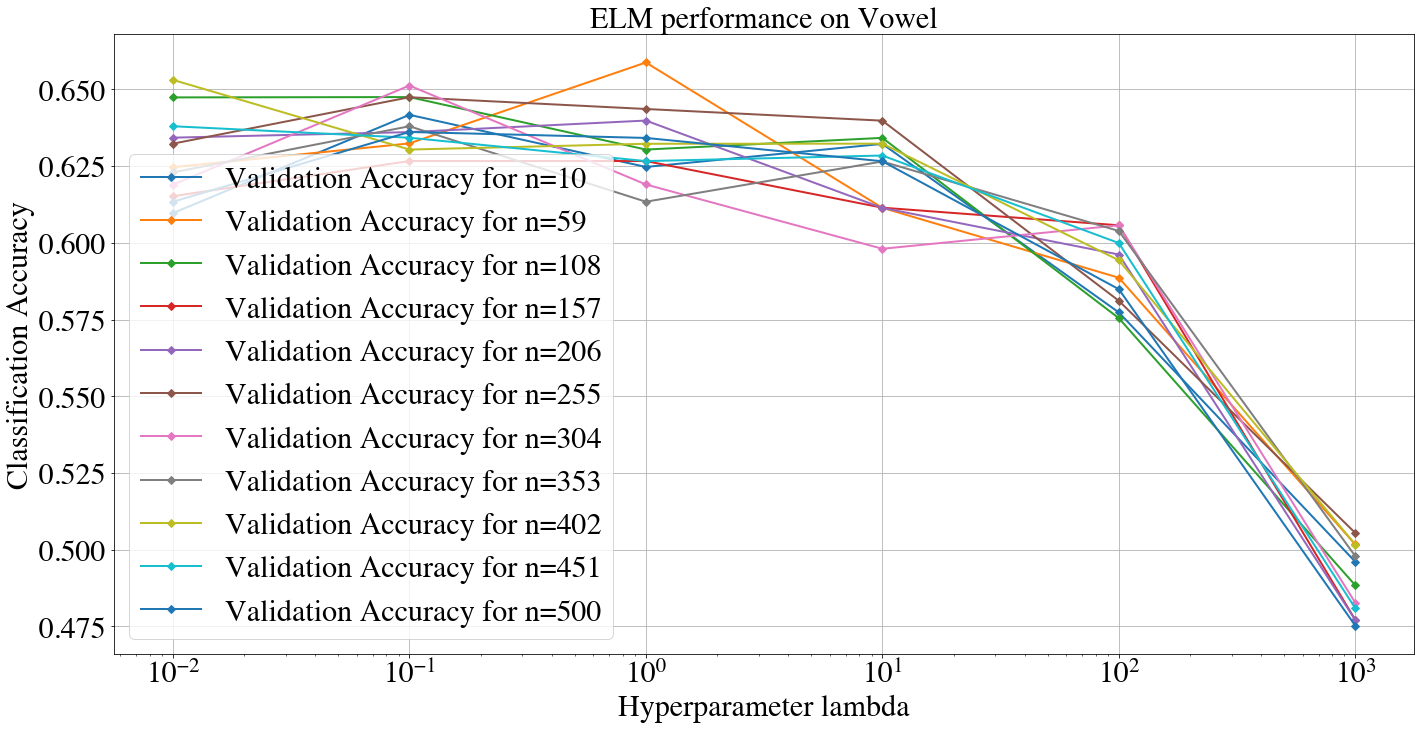

In [162]:
FontSize = 30
#csfont = {'fontname':'serif'}
plt.rc( 'font', size=30, family="Times" ) 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
#plt.plot(lam_arr, val_accuracy_lists, 'r-', label="Validation Accuracy")
#plt.plot(lam_arr, train_accuracy_lists, 'b-', label="Train Accuracy")
for i, n in enumerate(n_arr):
    mean_score_lambda_arr = np.array([[m, p['lam']] for p,m in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score']) if p['n'] == n])
    plt.plot(mean_score_lambda_arr[:,1], mean_score_lambda_arr[:,0],  'D-', label="Validation Accuracy for n={}".format(n), linewidth=2)

ax.set_xscale('log')
plt.grid()
plt.xticks(fontsize=FontSize)
plt.yticks(fontsize=FontSize)
plt.tight_layout()
plt.legend(loc='best',fontsize=FontSize)
plt.xlabel("Hyperparameter lambda", fontsize=FontSize)
plt.ylabel("Classification Accuracy", fontsize=FontSize)
plt.title("ELM performance on Vowel", loc='center', fontsize=FontSize)
plt.show()

## Get the accuracy results on test data

In [163]:
from sklearn.metrics import classification_report

In [164]:
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = np.argmax(grid.predict(X_test.T) , axis=0).reshape((-1, 1))
# print classification report 
print(classification_report(np.argmax(T_test, axis=0), grid_predictions)) 

{'lam': 1.0, 'n': 59}
              precision    recall  f1-score   support

           0       0.68      0.60      0.63        42
           1       0.38      0.55      0.45        42
           2       0.39      0.26      0.31        42
           3       0.36      0.60      0.45        42
           4       0.25      0.14      0.18        42
           5       0.44      0.71      0.55        42
           6       0.44      0.29      0.35        42
           7       0.71      0.60      0.65        42
           8       0.32      0.29      0.30        42
           9       0.35      0.43      0.38        42
          10       0.25      0.14      0.18        42

    accuracy                           0.42       462
   macro avg       0.42      0.42      0.40       462
weighted avg       0.42      0.42      0.40       462



In [165]:
print(grid_predictions.shape, T_test.shape)

(462, 1) (11, 462)


## Using kernels

### **Training ELM by using linear kernel**

We set the regularization hyperparameter alpha, and construct the kernel matrix for training and test data accordingly. In particular, the solution of the kernel method for a pair of $(\mathbf{y}_j,\mathbf{t}_j)$ can be written as 
\begin{align}
    \hat{\mathbf{t}}_j = \mathbf{T} (K + \alpha \mathbf{I})^{-1} k(\mathbf{y}_j),
\end{align}
where $\mathbf{K} \in \mathbb{R}^{J \times J}$ is the kernel matrix with elements $k_{ij}=\mathbf{k}(\mathbf{y}_i)^{'}\mathbf{k}(\mathbf{y}_j)$ for a given kernel $\mathbf{k}(\cdot)$. Note that $k(\mathbf{y}_j) \in \mathbb{R}^{J}$  is the product of sample $\mathbf{y}_j$ and training set with elements $k_{j}=\mathbf{k}(\mathbf{y}_i)^{'}\mathbf{k}(\mathbf{y}_j), \forall i = 1, \cdots, J$. In matrix form, we can write
\begin{align}
    \hat{\mathbf{T}}_{\text{test}} = \mathbf{T} (K + \alpha \mathbf{I})^{-1} K_{\text{test}},
\end{align}
where $K_{\text{test}} \in \mathbb{R}^{J \times J_{\text{test}}}$ is the kernel matrix between train and test samples for a given kernel $\mathbf{k}(\cdot)$. Now we apply a linear kernel $\mathbf{k}(\cdot)$ on the feature vectors of ELM in $\mathbf{Y}$ to predict the target.

In [166]:
class ELM_with_kernel(object):
    
    def __init__(self, n, alpha, P, kernel_type="linear"):
        self.n = n
        self.alpha = alpha
        self.Ri = self.initialise_random_matrix(M=n, N=P)
        self.b = self.initialise_random_matrix(M=n, N=1)
        self.W_ker = None
        self.kernel_type = kernel_type
        
    def linear_kernel(self, X, Y):
        return np.dot(X.T, Y)
        
    def rbf_kernel(self, X, Y):
        N1 = X.shape[1]
        N2 = Y.shape[1]
        n1sq = np.sum(np.square(X),axis=0)
        n2sq = np.sum(np.square(Y),axis=0)

        D = np.tile(n1sq, (N2, 1)).T + np.tile(n2sq, (N1, 1)) - 2 * np.dot(X.T, Y)  # the element i,j of this matrix are nothing but the individual distance of samples x_i and y_j meaning ||x_i - y_j||_2^2
        C = np.tile(n1sq, (N1, 1)).T + np.tile(n1sq, (N1, 1)) - 2 * np.dot(X.T, X)  # the element i,j of this matrix are nothing but the individual distance of samples x_i and x_j meaning ||x_i - x_j||_2^2
        temp = np.sum(C)/(N1*N1)    # temp represent the average distance of samples of X from each other. Note that C is zero on the diagonal.

        K = np.exp(-D/temp)     # note that in this way we don't need to tune the value of temp
        return K
    
    def activation_function(self, Z):
        return np.maximum(0, Z)

    def initialise_random_matrix(self, M, N):
        return np.random.uniform(low = -1, high = 1, size = (M,N)) 
        #return A - np.mean(A)
        #return np.random.normal(0, 1, size=(M, N))
    
    def train(self, X, T):
        
        P = X.shape[0]
        N = X.shape[1]
        Zi = np.dot(self.Ri, X) + np.tile(self.b,(1,N))
        Yi = self.activation_function(Z=Zi)
        if self.kernel_type == "linear":
            self.W_ker = np.dot(T, np.linalg.inv(self.linear_kernel(Yi,Yi) + self.alpha * np.eye(N))).astype(np.float32)
        elif self.kernel_type == "gaussian":
            self.W_ker = np.dot(T, np.linalg.inv(self.rbf_kernel(Yi,Yi) + self.alpha * np.eye(N))).astype(np.float32)
    
    def evaluate(self, X_train, X_test):
        
        N_train = X_train.shape[1]
        N_test = X_test.shape[1]
        
        Zi_train = np.dot(self.Ri, X_train) + np.tile(self.b,(1,N_train))
        Yi_train = self.activation_function(Z=Zi_train)
        
        Zi_test = np.dot(self.Ri, X_test) + np.tile(self.b,(1,N_test))
        Yi_test = self.activation_function(Z=Zi_test)
        
        if self.kernel_type == "linear":
            K_test = self.linear_kernel(Yi_train, Yi_test)
        elif self.kernel_type == "gaussian":
            K_test = self.rbf_kernel(Yi_train, Yi_test)
        
        T_hat = np.dot(self.W_ker, K_test)
        return T_hat

In [167]:
def train_ELM_with_kernel(X_train, T_train, X_val=None, T_val=None, n=2000, alpha=1e2, kernel_type="linear"):
    
    elm_net = ELM_with_kernel(n=n, alpha=alpha, P=X_train.shape[0], kernel_type=kernel_type)
    elm_net.train(X=X_train, T=T_train)
    T_hat_train = elm_net.evaluate(X_train=X_train, X_test=X_train)
    T_hat_val = elm_net.evaluate(X_train=X_train, X_test=X_val)
    acc_train = calculate_accuracy(T_hat_train, T_train)
    acc_val = calculate_accuracy(T_hat_val, T_val)
    
    return acc_train, acc_val, elm_net

In [168]:
grid.best_params_

{'lam': 1.0, 'n': 59}

In [170]:
acc_train_linear_kernel_star, acc_val_linear_kernel_star, elm_net_linear_kernel_star = train_ELM_with_kernel(X_train, T_train, X_val, T_val, 
                                                                                           n=grid.best_params_['n'], 
                                                                                           alpha=grid.best_params_['lam'],
                                                                                           kernel_type="linear")

T_hat_test_linear_kernel = elm_net_linear_kernel_star.evaluate(X_train=X_train, X_test=X_test)
acc_test_linear_kernel_star = calculate_accuracy(T_hat_test_linear_kernel, T_test)
print("Optimized Lambda: {}, Acc_train: {}, Acc_val: {}, Acc_test: {}".format(grid.best_params_['lam'], 
                                                                              acc_train_linear_kernel_star, 
                                                                              acc_val_linear_kernel_star, 
                                                                              acc_test_linear_kernel_star))

Optimized Lambda: 1.0, Acc_train: 0.8293838862559242, Acc_val: 0.6037735849056604, Acc_test: 0.42424242424242425


### Training with Gaussian kernels

In [177]:
acc_train_gaussian_kernel_star, acc_val_gaussian_kernel_star, elm_net_gaussian_kernel_star = train_ELM_with_kernel(X_train, T_train, X_val, T_val, 
                                                                                           n=grid.best_params_['n'], 
                                                                                           alpha=grid.best_params_['lam'],
                                                                                           kernel_type="gaussian")

T_hat_test_gaussian_kernel = elm_net_gaussian_kernel_star.evaluate(X_train=X_train, X_test=X_test)
acc_test_gaussian_kernel_star = calculate_accuracy(T_hat_test_gaussian_kernel, T_test)
print("Optimized Lambda: {}, Acc_train: {}, Acc_val: {}, Acc_test: {}".format(grid.best_params_['lam'], 
                                                                              acc_train_gaussian_kernel_star, 
                                                                              acc_val_gaussian_kernel_star, 
                                                                              acc_test_gaussian_kernel_star))

Optimized Lambda: 1.0, Acc_train: 0.8957345971563981, Acc_val: 0.7641509433962265, Acc_test: 0.5562770562770563
